<a href="https://colab.research.google.com/github/amalvarezme/MineriaDatos/blob/master/Sesion2_Regresion/ej_mainfifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2020-11-07 00:20:16--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 108.177.97.101, 108.177.97.138, 108.177.97.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-0s-docs.googleusercontent.com/docs/securesc/c7feo2lmhdk4j02lfgn5ujo1qt7u6smr/ff5hmc9ouc2ugbfelk9rpobq3a4bj5dm/1604708400000/09173029842254050324/06905904586479612871Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download [following]
--2020-11-07 00:20:19--  https://doc-0g-0s-docs.googleusercontent.com/docs/securesc/c7feo2lmhdk4j02lfgn5ujo1qt7u6smr/ff5hmc9ouc2ugbfelk9rpobq3a4bj5dm/1604708400000/09173029842254050324/06905904586479612871Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download
Resolving doc-0g-0s-docs.googleusercontent.com (doc-0g-0s-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to 

In [2]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#from funciones_fifa import dummy_fifa, pre_exploratorio, save_fig, code_euro

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline


import pandas as pd
%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv'

Xdata = pd.read_csv(csv_path)

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From']
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,7/1/2004,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,7/10/2018,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,8/3/2017,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,7/1/2011,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,8/30/2015,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

In [5]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


In [6]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
ytrain = imputer.fit_transform(pd.DataFrame(ytrain))
ytrain = ytrain.reshape(-1)

ytest = imputer.transform(pd.DataFrame(ytest))
ytest = ytest.reshape(-1)

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


In [9]:
a = ytrain[0]
print(a,a[1:-1])


€4.2M 4.2


In [11]:
#%%   
#codificar estadísticas -> jugadores fifa ej 88+3
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        #print(y.iloc[i])
        
        if y.iloc[i].find("+") > -1: # encontrar signo mas en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
        #print(yc[i])
    return yc   

#codificar moneda ->
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
      #  print(i,y[i])
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
        #print(yc[i])
    return yc 

In [12]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [13]:
ytrain_num[:5]

array([ 4200000.,   560000.,   798000., 16700000.,  2600000.])

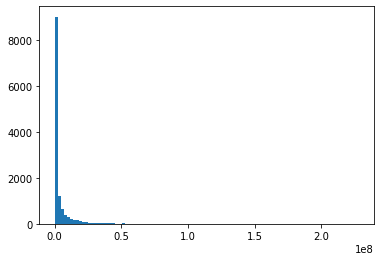

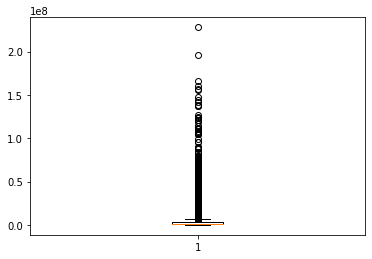

In [14]:
import matplotlib.pyplot as plt
plt.hist(ytrain_num,bins = 100)
plt.show()

plt.boxplot(ytrain_num)
plt.show()

In [26]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'];
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB'];

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))

# Crear clase propia de preproceso para Fifa

In [28]:
#%% dummy transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

class dummy_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo modo
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        #print(a)
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar  sobre datos imputador
        #print('Cod Euros\n')
        for i in self.col_euro: #codificar tipo moneda
         #   print(i)
            Xi[i] = code_euro(np.array(Xi[i]))
        #print('Cod stats\n')    
        for i in self.col_stats: #codificar datos estadisticos
         #   print(i)
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            #print(float(Xi.loc[i,'Weight'][:-3]))
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64');#print(Xi['Height'].dtype)
        
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        
        
        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        
        #self.col_cat = Xi.columns[Xi.dtypes=='O']
        #self.cod = OrdinalEncoder()
        #self.cod.fit(Xi[self.col_cat])
        
        return self    

    def transform(self, X, *_):#funcion transformador-> pensando datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])
        
        for i in self.col_euro:
         #   print(i)
            Xi[i] = code_euro(np.array(Xi[i]))
        #print('Cod stats\n')    
        for i in self.col_stats:
         #   print(i)
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            #print(float(Xi.loc[i,'Weight'][:-3]))
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')
            
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        #Xi[self.col_cat]= self.cod.transform(Xi[self.col_cat])
        return Xi
    
    def fit_transform(self,X,*_):
        self.fit(X)
        return self.transform(X)

In [29]:
dummy = dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = dummy.fit_transform(Xtrain)

In [30]:
Xtest_pre = dummy.transform(Xtest) #no se puede fit solo transform

In [31]:
Xtest_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5463 entries, 16647 to 8745
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       5463 non-null   int64  
 1   Nationality               5463 non-null   float64
 2   Overall                   5463 non-null   int64  
 3   Potential                 5463 non-null   int64  
 4   Club                      5463 non-null   float64
 5   Value                     5463 non-null   float64
 6   Wage                      5463 non-null   float64
 7   Special                   5463 non-null   int64  
 8   Preferred Foot            5463 non-null   float64
 9   International Reputation  5463 non-null   float64
 10  Weak Foot                 5463 non-null   float64
 11  Skill Moves               5463 non-null   float64
 12  Work Rate                 5463 non-null   float64
 13  Body Type                 5463 non-null   float64
 14  Real

In [32]:
corr_matrix = Xtrain_pre.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

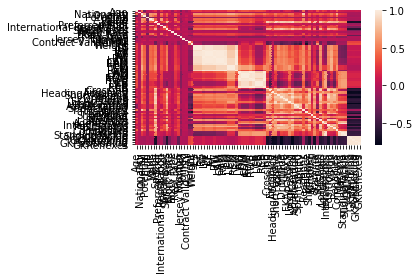

In [33]:
import seaborn as sns
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns.values,yticklabels=corr_matrix.columns.values)
plt.tight_layout()
#plt.savefig('results/corr_matrix.pdf', format='pdf', dpi=300)
plt.show()

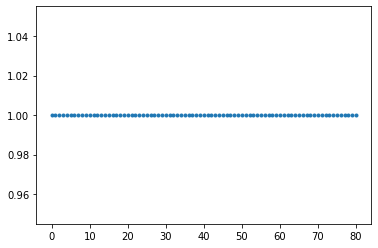

In [47]:
plt.plot(Xtrain_pre_z.var(axis=0),'.')

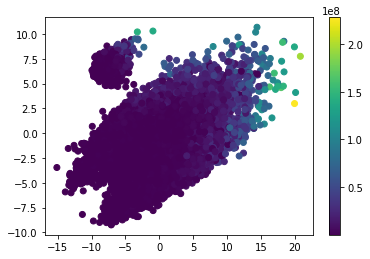

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sca = StandardScaler()# (col_j - mean_j)/std_j
sca.fit(Xtrain_pre)
Xtrain_pre_z = sca.transform(Xtrain_pre)

red = PCA(n_components=2)
red.fit(Xtrain_pre_z)
z = red.transform(Xtrain_pre_z)
z.shape
plt.scatter(z[:,0],z[:,1],c=ytrain_num)
plt.colorbar()
plt.show()

<StemContainer object of 3 artists>

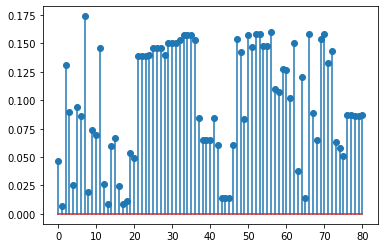

In [52]:
plt.stem(abs(red.components_[0]))

In [53]:
Xtrain_pre2 = Xtrain_pre.copy()
Xtrain_pre2['Salida'] = ytrain_num
corr_matrix = abs(Xtrain_pre2.corr())
corr_matrix['Salida'].sort_values(ascending=False)


Salida                      1.000000
Value                       0.971943
Wage                        0.824070
International Reputation    0.621493
Overall                     0.593941
                              ...   
GKDiving                    0.025756
GKPositioning               0.024579
Nationality                 0.015864
Preferred Foot              0.013920
Height                      0.013007
Name: Salida, Length: 82, dtype: float64

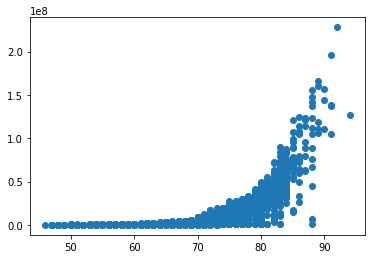

In [54]:
import matplotlib.pyplot as plt
plt.scatter(Xtrain_pre['Overall'],ytrain_num)

# Modelo de regresión

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,SGDRegressor

steps = [('preproceso',dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)), 
         ('scaler',StandardScaler()),
         ('red',PCA(n_components=0.9)),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full

metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos

Pipeline(memory=None,
         steps=[('preproceso',
                 dummy_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Messi', 'Akinfenwa',
                                                   'C. Ronaldo', 'Courtois',
                                                   'Shaqiri', 'Neymar'],
                                     'Club': ['Real Madrid', 'Burnley',
                                              'Valencia CF', 'Cardiff City',
                                              'Chelsea', 'Frosinone',
                                              'Rayo Vallecano', 'Everton',
                                              'CD Leganés',
                                              'TSG 1899 Hoffenheim',
                                              'Manchester City', 'Empoli',
                                              'S...
                     

In [62]:
ytest_e = metodo_full.predict(Xtest)



<StemContainer object of 3 artists>

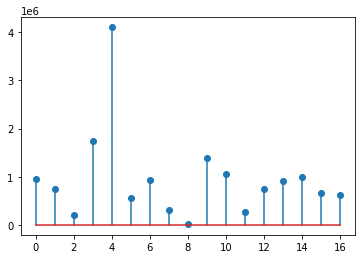

In [64]:
plt.stem(abs(metodo_full[3].coef_))

In [ ]:
Xtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5463 entries, 14198 to 12216
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       5463 non-null   int64  
 1   Nationality               5463 non-null   object 
 2   Overall                   5463 non-null   int64  
 3   Potential                 5463 non-null   int64  
 4   Club                      5389 non-null   object 
 5   Value                     5463 non-null   object 
 6   Wage                      5463 non-null   object 
 7   Special                   5463 non-null   int64  
 8   Preferred Foot            5454 non-null   object 
 9   International Reputation  5454 non-null   float64
 10  Weak Foot                 5454 non-null   float64
 11  Skill Moves               5454 non-null   float64
 12  Work Rate                 5454 non-null   object 
 13  Body Type                 5454 non-null   object 
 14  Rea

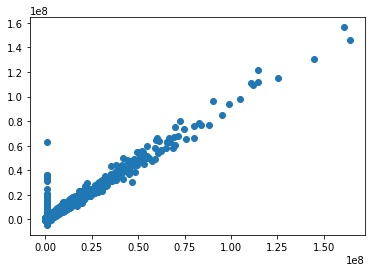

In [ ]:
#plt.plot(ytest_num,label='original')
#plt.plot(ytest_e,'r',label='estimado')
plt.scatter(ytest_num,ytest_e)

#plt.legend()

In [ ]:
metodo_full.steps[1][1]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
metodo_full.classes_

AttributeError: ignored

In [ ]:
metodo_full

Pipeline(memory=None,
         steps=[('preproceso',
                 dummy_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Neymar', 'C. Ronaldo',
                                                   'Akinfenwa', 'Messi',
                                                   'Shaqiri',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Courtois'],
                                     'Club': ['Real Madrid', 'Chelsea',
                                              'FC Barcelona', 'CD Leganés',
                                              'Valencia CF', 'Everton',
                                              'Empoli', 'Rayo Vallecano',
                                              'Frosinone', 'Cardiff City',
                                              'Borussia Dortmund', 'AS Monaco',
                                              'Newc...
                